# LSTM con viento

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
df = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_train_2015.csv', index_col=0, parse_dates=True)
df = df.asfreq('h')

In [ ]:
df = df.between_time('09:00:00','18:00:00')

In [ ]:
df = df[['SRGLOAVG1H','TAMAX1H','TAMIN1H','WS1HX','WS1HA','RHMIN1H','RHMAX1H']]

In [ ]:
df_test = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_test_2015.csv', index_col=0, parse_dates=True)
df_test = df_test.asfreq('h')

In [ ]:
df_test = df_test[['SRGLOAVG1H','TAMAX1H','TAMIN1H','WS1HX','WS1HA','RHMIN1H','RHMAX1H']]
df_test = df_test.between_time('09:00:00','18:00:00')

In [ ]:
velocidad_viento = df['WS1HA'].values

In [ ]:
import statsmodels.graphics.tsaplots as sgt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


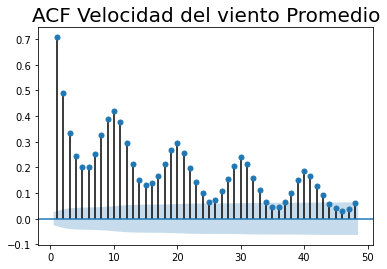

In [ ]:
sgt.plot_acf(velocidad_viento, lags = 48, zero = False)
plt.title("ACF Velocidad del viento Promedio", size = 20)
plt.show()

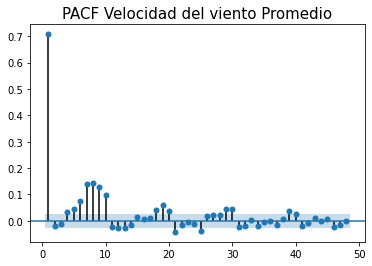

In [ ]:
sgt.plot_pacf(velocidad_viento, lags = 48, zero = False, method = ('ols'))
plt.title("PACF Velocidad del viento Promedio", size = 15)
plt.show()

In [ ]:
velocidad_viento = np.reshape(velocidad_viento,(-1,1))

In [ ]:
velocidad_viento_test = df_test['WS1HA'].values
velocidad_viento_test = np.reshape(velocidad_viento_test,(-1,1))

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scaler.fit(velocidad_viento)
scaled_train = scaler.transform(velocidad_viento)
scaled_test = scaler.transform(velocidad_viento_test)

In [ ]:
scaled_train[0]

array([0.36666667])

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

## Buscando los mejores parámetros

In [ ]:
import json

In [ ]:
resultados_anteriores = []

In [ ]:
with open("/content/resultados.txt",'r') as fp:
    for line in fp:
      resultados_anteriores.append(json.loads(line))

In [ ]:
df_resultados_anteriores = pd.DataFrame(resultados_anteriores)

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
n_input = 10 # horas hacia atrás
n_features = 0 # variables exógenas

In [ ]:
def create_Model(n_input, LSTM_neurons = 100, layers=3,n_features=0):
  # define model
  model = Sequential()
  if(layers>1):
    model.add(LSTM(LSTM_neurons, activation='relu', input_shape=(n_input, n_features+1),return_sequences=True))
    for i in range(layers-2):
        model.add(LSTM(LSTM_neurons, activation='relu',return_sequences=True))
    model.add(LSTM(LSTM_neurons, activation='relu'))
  else:
    model.add(LSTM(LSTM_neurons, activation='relu', input_shape=(n_input, n_features+1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  return model

In [ ]:
model = create_Model(10,100,1)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 100)               40800     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)  

In [ ]:
batch_size = 150

In [ ]:
model.fit(generator,epochs=7,verbose=True,batch_size=batch_size)


Epoch 1/7
5840/5840 [==============================] - 33s 5ms/step - loss: 0.0183
Epoch 2/7
5840/5840 [==============================] - 31s 5ms/step - loss: 0.0157
Epoch 3/7
5840/5840 [==============================] - 33s 6ms/step - loss: 0.0151
Epoch 4/7
5840/5840 [==============================] - 32s 5ms/step - loss: 0.0147
Epoch 5/7
5840/5840 [==============================] - 31s 5ms/step - loss: 0.0146
Epoch 6/7
5840/5840 [==============================] - 33s 6ms/step - loss: 0.0145
Epoch 7/7
5840/5840 [==============================] - 32s 5ms/step - loss: 0.0143


In [ ]:
resultados=[]
combinaciones_anteriores = []

In [ ]:
df_resultados = pd.concat([df_resultados,df_resultados_anteriores],ignore_index=True)

NameError: ignored

In [ ]:
for i in range(len(df_resultados)):
  combinaciones_anteriores.append((int(df_resultados.iloc[i]['Retrasos']),
                                   int(df_resultados.iloc[i]['Neuronas LSTM']),
                                   int(df_resultados.iloc[i]['Batch size']),
                                   int(df_resultados.iloc[i]['LSTM Layers'])))

In [ ]:
combinaciones_anteriores[-1]

(25, 100, 50, 2)

In [ ]:
for retrasos in range(10,26,5): #hasta dos días y medio hacia el pasado
  for num_neuronas in range(50,101,25): 
    for batch_size in range(50,151,50):
      for num_layers in range(1,4): 
        if((retrasos,num_neuronas,batch_size,num_layers) in combinaciones_anteriores):
          continue
        n_input = retrasos # horas hacia atrás
        n_features = 0 # variables exógenas
        generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)  
        model = create_Model(n_input,LSTM_neurons=num_neuronas,layers=num_layers)
        model.fit(generator,epochs=7,verbose=False,batch_size=batch_size)
        predictions = []
        for j in range(n_input,len(df_test)):
          model_input = scaled_test[j-n_input:j]
          model_input = model_input.reshape((1, n_input, n_features+1))
          predictions.append(model.predict(model_input)[0])
        predictions = np.ndarray.flatten(np.array(predictions))  
        true_predictions = scaler.inverse_transform(np.reshape(predictions,(-1,1)))
        true_values = np.ndarray.flatten(df_test.iloc[n_input:]['WS1HA'].values)
        errorMSE = mean_squared_error(true_values,true_predictions)
        errorMAE = mean_absolute_error(true_values,true_predictions)
        print({
            'Retrasos':retrasos,
            'Neuronas LSTM':num_neuronas,
            'LSTM Layers': num_layers,
            'Batch size':batch_size,
            'MSE':errorMSE,
            'MAE':errorMAE
        })
        resultados.append({
            'Retrasos':retrasos,
            'Neuronas LSTM':num_neuronas,
            'LSTM Layers': num_layers,
            'Batch size':batch_size,
            'MSE':errorMSE,
            'MAE':errorMAE
        })

{'Retrasos': 25, 'Neuronas LSTM': 100, 'LSTM Layers': 3, 'Batch size': 50, 'MSE': 1.496298246624995, 'MAE': 0.9262479407280579}
{'Retrasos': 25, 'Neuronas LSTM': 100, 'LSTM Layers': 1, 'Batch size': 100, 'MSE': 1.389976227176217, 'MAE': 0.9093344981662073}
{'Retrasos': 25, 'Neuronas LSTM': 100, 'LSTM Layers': 2, 'Batch size': 100, 'MSE': 1.5111005427235713, 'MAE': 0.937857000287817}
{'Retrasos': 25, 'Neuronas LSTM': 100, 'LSTM Layers': 3, 'Batch size': 100, 'MSE': 1.4721632738343007, 'MAE': 0.9336420421400967}
{'Retrasos': 25, 'Neuronas LSTM': 100, 'LSTM Layers': 1, 'Batch size': 150, 'MSE': 1.4197968823174207, 'MAE': 0.9027691280717218}
{'Retrasos': 25, 'Neuronas LSTM': 100, 'LSTM Layers': 2, 'Batch size': 150, 'MSE': 1.4506947167554163, 'MAE': 0.9246992079970728}
{'Retrasos': 25, 'Neuronas LSTM': 100, 'LSTM Layers': 3, 'Batch size': 150, 'MSE': 1.753556391313874, 'MAE': 1.0510087209628434}


El viento se mide en m/s

In [ ]:
resultados[0]

{'Batch size': 50,
 'LSTM Layers': 2,
 'MAE': 0.9317319227511044,
 'MSE': 1.5020954829739526,
 'Neuronas LSTM': 50,
 'Retrasos': 25}

In [ ]:
df_resultados_actuales = pd.DataFrame(resultados)

In [ ]:
df_resultados_actuales

,Retrasos,Neuronas LSTM,LSTM Layers,Batch size,MSE,MAE
0,25,100,3,50,1.496298,0.926248
1,25,100,1,100,1.389976,0.909334
2,25,100,2,100,1.511101,0.937857
3,25,100,3,100,1.472163,0.933642
4,25,100,1,150,1.419797,0.902769
5,25,100,2,150,1.450695,0.924699
6,25,100,3,150,1.753556,1.051009


In [ ]:
df_resultados = pd.concat([df_resultados,df_resultados_actuales])

In [ ]:
df_resultados

,Retrasos,Neuronas LSTM,LSTM Layers,Batch size,MSE,MAE
0,10,50,1,50,1.544408,0.947084
1,10,50,2,50,1.472445,0.929781
2,10,50,3,50,1.467663,0.935952
3,10,50,1,100,1.454685,0.917162
4,10,50,2,100,1.436064,0.909134
...,...,...,...,...,...,...
2,25,100,2,100,1.511101,0.937857
3,25,100,3,100,1.472163,0.933642
4,25,100,1,150,1.419797,0.902769
5,25,100,2,150,1.450695,0.924699


In [ ]:
df_resultados.to_csv('./drive/MyDrive/DatosInvestigacion/lstm_viento_resultados.csv',index=False)

In [ ]:
df_resultados = pd.read_csv('./drive/MyDrive/DatosInvestigacion/lstm_viento_resultados.csv')